In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Load images

In [2]:
imsize = 256  
def load_image(image_path, transform=None, max_size=imsize, shape=None):
    image = Image.open(image_path).convert('RGB')
    if max_size is not None:
        size = max(image.size)
        if size > max_size:
            size = max_size
        else:
            size = image.size[0]  # if already small, keep size
    if shape is not None:
        size = shape
        
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize((imsize, imsize)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.ToTensor()
        ])
    image = transform(image).unsqueeze(0)  # add batch dimension
    return image.to(device, torch.float)

def imshow(tensor, title=None):
    """
    Display a tensor as an image inline in the notebook.
    """
    image = tensor.cpu().clone().detach().squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

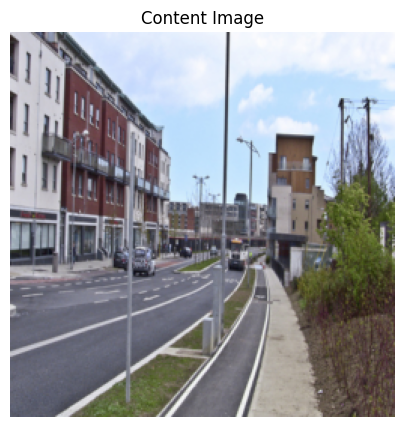

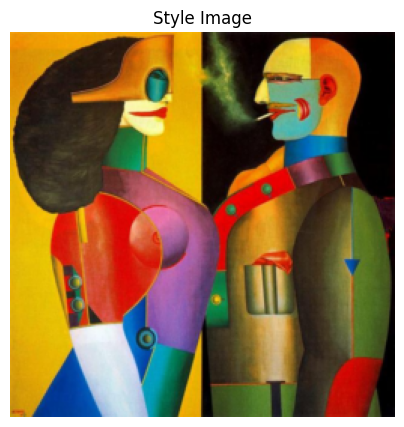

In [38]:
content_dir = "/kaggle/input/cv-a2-dataset/datasets/CV Assignment 2/Q3/content"
style_dir = "/kaggle/input/cv-a2-dataset/datasets/CV Assignment 2/Q3/styles"

imsize = 256

loader = transforms.Compose([
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor()
    ])

content_files = os.listdir(content_dir)
style_files = os.listdir(style_dir)

content_image_path = os.path.join(content_dir, content_files[9])
style_image_path = os.path.join(style_dir, style_files[9])

content_img = load_image(content_image_path, transform=loader)
style_img = load_image(style_image_path, transform=loader)

# Display the loaded images
imshow(content_img, title="Content Image")
imshow(style_img, title="Style Image")

## Loss functions

In [39]:
def content_loss_func(F_content, F_generated):
    """
    Computes the content loss as the squared difference between
    content and generated feature maps.
    L_content = ||F_content - F_generated||^2
    """
    return torch.mean((F_content - F_generated) ** 2)

def gram_matrix(feature_maps):
    """
    Computes the Gram matrix from feature maps.
    Input: feature_maps of shape (1, C, H, W)
    Output: Gram matrix of shape (C, C), normalized by (C * H * W)
    """
    b, c, h, w = feature_maps.size()
    features = feature_maps.view(c, h * w)
    G = torch.mm(features, features.t())
    return G.div(c * h * w)

def style_loss_func(F_style, F_generated):
    """
    Computes the style loss as the MSE between the Gram matrices of the
    style image and the generated image.
    """
    G_style = gram_matrix(F_style)
    G_generated = gram_matrix(F_generated)
    return torch.mean((G_style - G_generated) ** 2)

## Load VGG features

In [40]:
class VGGFeatures(nn.Module):
    """
    A module to extract features from selected layers of VGG19.
    Adjust the layers as needed.
    """
    def __init__(self, vgg, content_layers, style_layers):
        super(VGGFeatures, self).__init__()
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.model = nn.Sequential()
        self.layer_mapping = {}  # map layer names to indices
        
        i = 0  # counter for conv layers
        for layer in vgg.features.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = f'conv{i}'
            elif isinstance(layer, nn.ReLU):
                name = f'relu{i}'
                # Use out-of-place ReLU to prevent in-place modifications
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = f'pool{i}'
            elif isinstance(layer, nn.BatchNorm2d):
                name = f'bn{i}'
            else:
                name = str(layer.__class__.__name__)
            self.model.add_module(name, layer)
            self.layer_mapping[name] = len(self.model) - 1

        # Freeze parameters
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, x):
        content_features = {}
        style_features = {}
        for name, layer in self.model._modules.items():
            x = layer(x)
            if name in self.content_layers:
                content_features[name] = x
            if name in self.style_layers:
                style_features[name] = x
        return content_features, style_features


In [41]:
def run_style_transfer(vgg_features, content_img, style_img, input_img, 
                       content_weight, style_weight, optimizer_name='LBFGS', 
                       num_steps=300):
    
    print(f"Starting style transfer using {optimizer_name} optimizer.")
    
    # Make sure the input image requires gradient
    input_img = input_img.clone().requires_grad_(True)

    # Define optimizer
    if optimizer_name == 'LBFGS':
        optimizer = optim.LBFGS([input_img], lr=0.01)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam([input_img], lr=0.01)
    else:
        raise ValueError("Unsupported optimizer. Choose 'LBFGS' or 'Adam'.")

    # Extract features of the target images
    target_content_features, _ = vgg_features(content_img)
    _, target_style_features = vgg_features(style_img)

    iteration = [0]  # use list to allow modifications in closure

    # Closure function for LBFGS (and used for Adam as well)
    def closure():
        optimizer.zero_grad()
        generated_content_features, generated_style_features = vgg_features(input_img)
        
        # Compute content loss (using the specified content layers, e.g., 'conv4')
        content_loss = 0
        for layer in vgg_features.content_layers:
            content_loss += content_loss_func(target_content_features[layer],
                                              generated_content_features[layer])
        
        # Compute style loss (summing losses from specified style layers)
        style_loss = 0
        for layer in vgg_features.style_layers:
            style_loss += style_loss_func(target_style_features[layer],
                                          generated_style_features[layer])
        
        total_loss = content_weight * content_loss + style_weight * style_loss
        total_loss.backward()
        
        # Clamp pixel values to [0, 1]
        with torch.no_grad():
            input_img.clamp_(0, 1)
        
        if iteration[0] % 300 == 0:
            print(f"Iteration {iteration[0]}: Content Loss: {content_loss.item():.7f}, "
                  f"Style Loss: {style_loss.item():.7f}, Total Loss: {total_loss.item():.4f}")
        iteration[0] += 1
        
        return total_loss


    start_time = time.time()
    for step in range(num_steps):
        optimizer.step(closure)
    end_time = time.time()
    print(f"Style transfer completed in {end_time - start_time:.2f} seconds.")

    # Final clamping
    with torch.no_grad():
        input_img.clamp_(0, 1)
    return input_img.detach()

## Varying content weights

In [44]:
def call_transfer(weight_configs):
    config_id = 1
    for content_weight, style_weight in weight_configs:
        for opt_name in optimizers_to_test:
            print(f"\n=== Running config {config_id}: {opt_name} optimizer with "
                  f"content_weight={content_weight}, style_weight={style_weight} ===")
            # Start with a copy of the content image as the initial input
            input_img = content_img.clone()
            output = run_style_transfer(vgg_features, content_img, style_img, input_img,
                                        content_weight, style_weight, optimizer_name=opt_name, num_steps=300)
            # Display the output image inline
            imshow(output, title=f"Output: Config {config_id}, {opt_name}")
        config_id += 1

content_layers = ['conv4']
style_layers = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5']

vgg = models.vgg19(pretrained=True).to(device).eval()
vgg_features = VGGFeatures(vgg, content_layers, style_layers).to(device)

optimizers_to_test = ['LBFGS', 'Adam']

weight_configs = [
    (1, 1e6),
    (10, 1e6),
    (1e2, 1e6),
]


=== Running config 1: LBFGS optimizer with content_weight=1, style_weight=1000000.0 ===
Starting style transfer using LBFGS optimizer.
Iteration 0: Content Loss: 0.0000000, Style Loss: 0.0003468, Total Loss: 346.8000
Iteration 1000: Content Loss: 2.6774242, Style Loss: 0.0000248, Total Loss: 27.4290
Iteration 2000: Content Loss: 3.1599841, Style Loss: 0.0000100, Total Loss: 13.2034
Iteration 3000: Content Loss: 3.0868917, Style Loss: 0.0000033, Total Loss: 6.4135
Iteration 4000: Content Loss: 2.8697138, Style Loss: 0.0000019, Total Loss: 4.8131
Iteration 5000: Content Loss: 2.8156052, Style Loss: 0.0000018, Total Loss: 4.6461
Style transfer completed in 174.71 seconds.


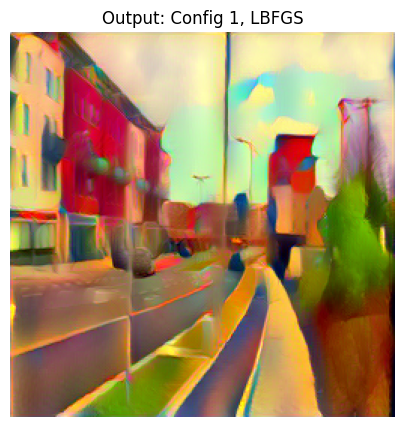


=== Running config 1: Adam optimizer with content_weight=1, style_weight=1000000.0 ===
Starting style transfer using Adam optimizer.
Iteration 0: Content Loss: 0.0000000, Style Loss: 0.0003468, Total Loss: 346.8000
Style transfer completed in 6.17 seconds.


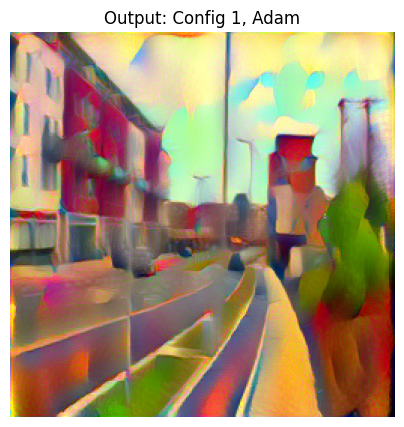


=== Running config 2: LBFGS optimizer with content_weight=10, style_weight=1000000.0 ===
Starting style transfer using LBFGS optimizer.
Iteration 0: Content Loss: 0.0000000, Style Loss: 0.0003468, Total Loss: 346.8000
Iteration 1000: Content Loss: 1.7344220, Style Loss: 0.0000284, Total Loss: 45.7869
Iteration 2000: Content Loss: 1.6848886, Style Loss: 0.0000197, Total Loss: 36.5288
Iteration 3000: Content Loss: 1.6659997, Style Loss: 0.0000175, Total Loss: 34.1961
Iteration 4000: Content Loss: 1.6640252, Style Loss: 0.0000160, Total Loss: 32.6774
Iteration 5000: Content Loss: 1.7042840, Style Loss: 0.0000109, Total Loss: 27.9691
Style transfer completed in 174.47 seconds.


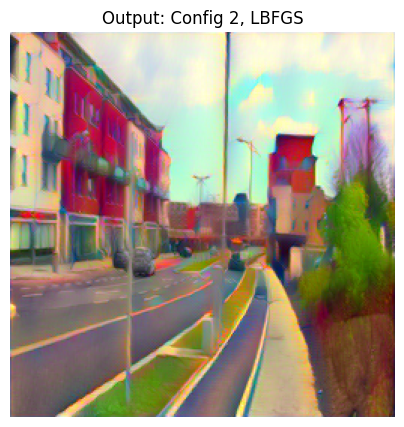


=== Running config 2: Adam optimizer with content_weight=10, style_weight=1000000.0 ===
Starting style transfer using Adam optimizer.
Iteration 0: Content Loss: 0.0000000, Style Loss: 0.0003468, Total Loss: 346.8000
Style transfer completed in 6.18 seconds.


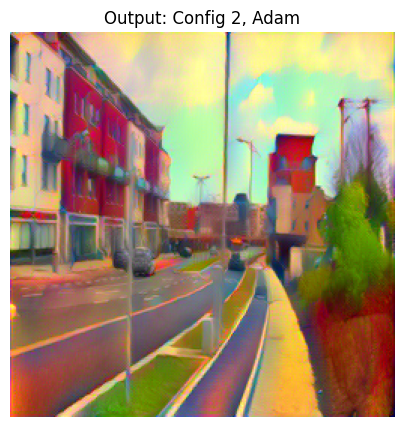


=== Running config 3: LBFGS optimizer with content_weight=100.0, style_weight=1000000.0 ===
Starting style transfer using LBFGS optimizer.
Iteration 0: Content Loss: 0.0000000, Style Loss: 0.0003468, Total Loss: 346.8000
Iteration 1000: Content Loss: 0.5588127, Style Loss: 0.0000735, Total Loss: 129.3967
Iteration 2000: Content Loss: 0.5385960, Style Loss: 0.0000725, Total Loss: 126.4082
Iteration 3000: Content Loss: 0.5437440, Style Loss: 0.0000688, Total Loss: 123.2222
Iteration 4000: Content Loss: 0.5463629, Style Loss: 0.0000671, Total Loss: 121.7176
Iteration 5000: Content Loss: 0.5542571, Style Loss: 0.0000640, Total Loss: 119.4572
Style transfer completed in 174.16 seconds.


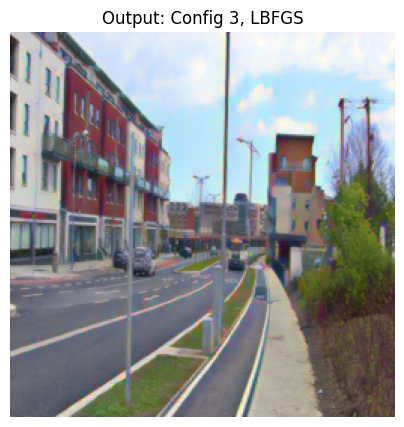


=== Running config 3: Adam optimizer with content_weight=100.0, style_weight=1000000.0 ===
Starting style transfer using Adam optimizer.
Iteration 0: Content Loss: 0.0000000, Style Loss: 0.0003468, Total Loss: 346.8000
Style transfer completed in 6.18 seconds.


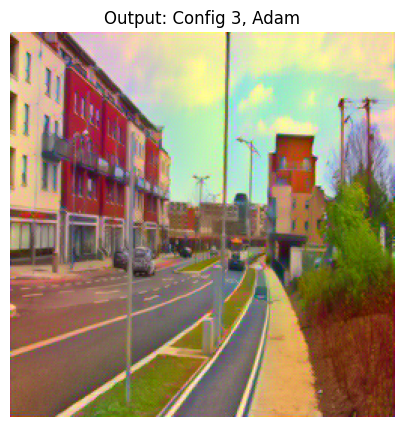

In [45]:
call_transfer(weight_configs)

### Varying style weights


=== Running config 1: LBFGS optimizer with content_weight=1, style_weight=10000000.0 ===
Starting style transfer using LBFGS optimizer.
Iteration 0: Content Loss: 0.0000000, Style Loss: 0.0003468, Total Loss: 3467.9995
Iteration 1000: Content Loss: 2.8258710, Style Loss: 0.0000245, Total Loss: 247.3385
Iteration 2000: Content Loss: 3.8283837, Style Loss: 0.0000093, Total Loss: 96.8626
Iteration 3000: Content Loss: 4.3915091, Style Loss: 0.0000024, Total Loss: 28.8598
Iteration 4000: Content Loss: 4.3865218, Style Loss: 0.0000009, Total Loss: 13.8108
Iteration 5000: Content Loss: 4.1827173, Style Loss: 0.0000005, Total Loss: 9.3168
Style transfer completed in 174.53 seconds.


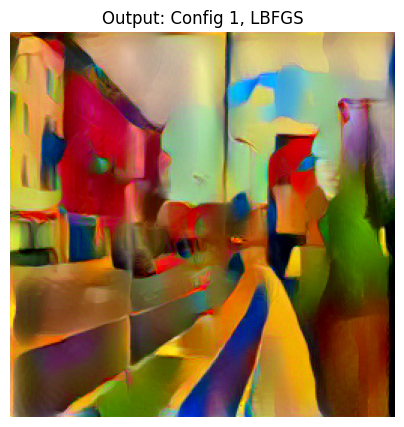


=== Running config 1: Adam optimizer with content_weight=1, style_weight=10000000.0 ===
Starting style transfer using Adam optimizer.
Iteration 0: Content Loss: 0.0000000, Style Loss: 0.0003468, Total Loss: 3467.9995
Style transfer completed in 6.17 seconds.


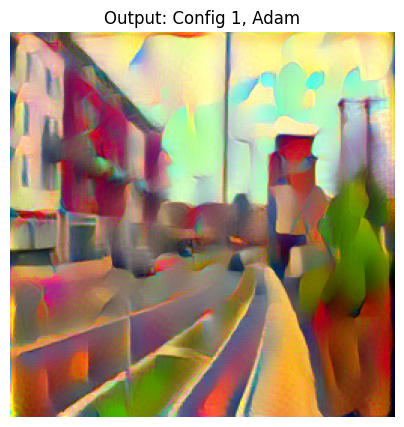


=== Running config 2: LBFGS optimizer with content_weight=1, style_weight=100000000.0 ===
Starting style transfer using LBFGS optimizer.
Iteration 0: Content Loss: 0.0000000, Style Loss: 0.0003468, Total Loss: 34679.9961
Iteration 1000: Content Loss: 2.8399086, Style Loss: 0.0000244, Total Loss: 2447.0486
Iteration 2000: Content Loss: 3.9024446, Style Loss: 0.0000094, Total Loss: 941.8220
Iteration 3000: Content Loss: 14.3685808, Style Loss: 0.0050559, Total Loss: 505606.3125
Iteration 4000: Content Loss: 8.6237593, Style Loss: 0.0000849, Total Loss: 8503.5049
Iteration 5000: Content Loss: 8.4287376, Style Loss: 0.0000168, Total Loss: 1685.2681
Style transfer completed in 174.08 seconds.


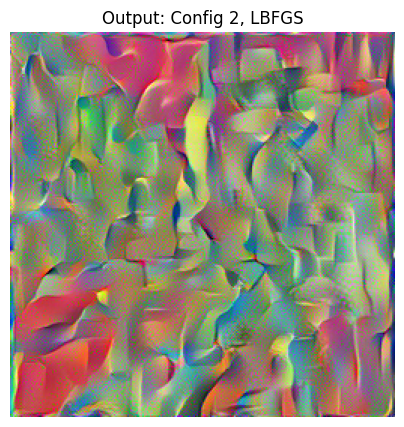


=== Running config 2: Adam optimizer with content_weight=1, style_weight=100000000.0 ===
Starting style transfer using Adam optimizer.
Iteration 0: Content Loss: 0.0000000, Style Loss: 0.0003468, Total Loss: 34679.9961
Style transfer completed in 6.17 seconds.


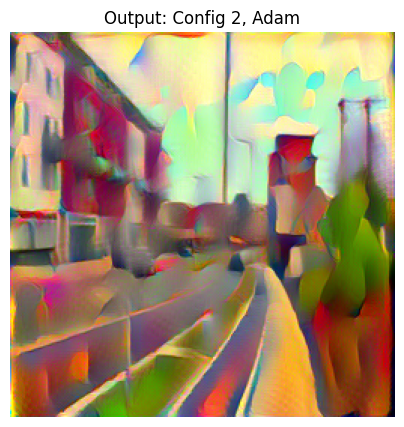


=== Running config 3: LBFGS optimizer with content_weight=1, style_weight=10000000000.0 ===
Starting style transfer using LBFGS optimizer.
Iteration 0: Content Loss: 0.0000000, Style Loss: 0.0003468, Total Loss: 3467999.7500
Iteration 1000: Content Loss: 2.8404970, Style Loss: 0.0000245, Total Loss: 244735.2500
Iteration 2000: Content Loss: 3.9092574, Style Loss: 0.0000094, Total Loss: 93878.2422
Iteration 3000: Content Loss: 4.6708460, Style Loss: 0.0000025, Total Loss: 25317.6914
Iteration 4000: Content Loss: 4.9710250, Style Loss: 0.0000014, Total Loss: 13735.2861
Iteration 5000: Content Loss: 12.8974590, Style Loss: 0.0044821, Total Loss: 44821048.0000
Style transfer completed in 173.88 seconds.


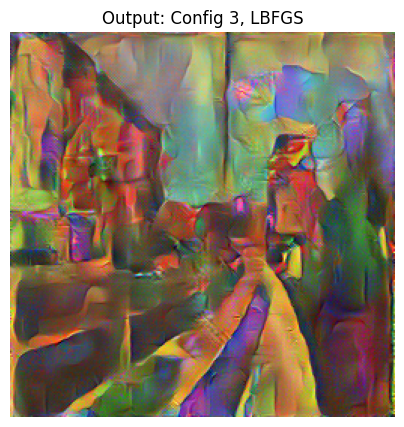


=== Running config 3: Adam optimizer with content_weight=1, style_weight=10000000000.0 ===
Starting style transfer using Adam optimizer.
Iteration 0: Content Loss: 0.0000000, Style Loss: 0.0003468, Total Loss: 3467999.7500
Style transfer completed in 6.16 seconds.


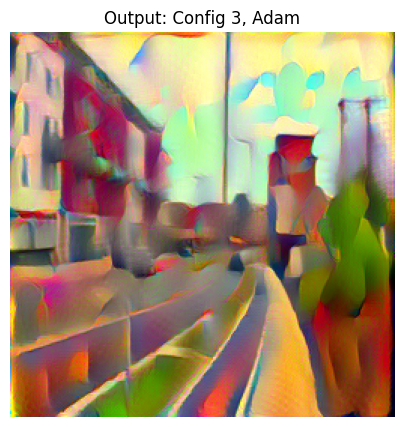

In [47]:
weight_configs = [
    (1, 1e7),
    (1, 1e8),
    (1, 1e10),
]
call_transfer(weight_configs)

### Observations

1. Increasing the weight for content or style results in a corresponding increase in the respective loss.
2. As the content weight increases while the style weight remains constant, the content image retains more of its original structure, leading to reduced style transfer.
3. As the style weight increases while the content weight remains constant, the content image adopts more stylistic features, enhancing the style transfer effect.
4. For higher style weights, LFGBS performs better than Adam mostly. However as the content weight is increased, Adam might perform better in certain cases
5. For very high ratio of content to style weights, the content image competely loses originality. 